1. Запросы в candidates для извлечения min_ts для каждого элемента
2. Маппинг элементов с их головными элементами (если такой есть). Головной элемент это тот, чей uid указан в качестве unified_uid в mapping.
3. Запросы в candidates для подсчета количества просмотров за первые три месяца фильма с трешхолдами watched_ratio > 0.5 и watched_ratio > 0.3. Также для первого месяца с watched_ratio > 0.5.
4. Мерджинг просмотры айтемов, активных юзеров по месяцам и контент фичи. Создание итогового таргета с использованием просмотров за 3 месяца с трешхолдом watched_ratio > 0.5 для фильмов и watched_ratio > 0.3 для сериалов. + разделить на сумму активных пользователей за 3 месяца.

In [6]:
import pandas as pd
import numpy as np
from datetime import date
from scipy import sparse

import msgpack
import boto3
import awswrangler as wr
from io import BytesIO
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml import Pipeline

import json

np.random.seed(1)

In [7]:
ACCESS_KEY='du3wAsX0uzEBBn4AdkFpCX4ZTXvSWFVG48GA4jbT'
SECRET_KEY='WA0NJOX0AFAY4K1J92XZ'

wr.config.s3_endpoint_url = 'https://obs.ru-moscow-1.hc.sbercloud.ru'

boto3.setup_default_session(
    region_name='ru-moscow',
    aws_access_key_id=SECRET_KEY,
    aws_secret_access_key=ACCESS_KEY,
)

def _get_default_boto3_client():
    return boto3.client('s3', endpoint_url=wr.config.s3_endpoint_url)

def get_object(s3_url):
    s3_client = _get_default_boto3_client()
    bucket, key = _split_3s_url_to_bucket_and_key(s3_url)
    return s3_client.get_object(Bucket=bucket, Key=key)

In [8]:
spark = SparkSession.builder.appName("Dummy").master('local').getOrCreate()
print("session = ", spark.getActiveSession())
config_spark_s3_adv = {'access_id': 'JLTHDJMKGTSENNZLD5YC',
                        'access_key': 'gtlSwf2xuppeomzYaAN3OFpcJiWtgAGUWNU7KIvJ',
                        'impl': 'org.apache.hadoop.fs.s3a.S3AFileSystem',
                        'endpoint': 'https://obs.ru-moscow-1.hc.sbercloud.ru'}

spark._jsc.hadoopConfiguration().set("fs.s3a.impl", config_spark_s3_adv["impl"])
spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", config_spark_s3_adv["endpoint"])
spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", config_spark_s3_adv["access_id"])
spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", config_spark_s3_adv["access_key"])
spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider")

22/11/14 16:15:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/14 16:15:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


session =  <pyspark.sql.session.SparkSession object at 0x7fc325213ca0>


# Candidates

In [6]:
path_candidates = 's3a://okko-prod/pipelines/etl-candidates_0.1/202209192359/outgoing/candidates.parquet'

In [7]:
full_candidates = spark.read.format('parquet').load(path_candidates)

22/10/31 12:23:46 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [8]:
full_candidates.printSchema()

root
 |-- element_uid: string (nullable = true)
 |-- user_uid: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- consumption_mode: string (nullable = true)
 |-- watched_time: integer (nullable = true)
 |-- watched_ratio: double (nullable = true)
 |-- bookmark: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [9]:
full_candidates.show()

+--------------------+--------------------+-------------------+----------------+------------+--------------------+--------+------+
|         element_uid|            user_uid|                 ts|consumption_mode|watched_time|       watched_ratio|bookmark|rating|
+--------------------+--------------------+-------------------+----------------+------------+--------------------+--------+------+
|000d6913-68a1-413...|00000000-0019-5c8...|2021-08-12 17:12:54|               S|        2066|  0.4420196833547283|       0|     0|
|000d6913-68a1-413...|00000000-09eb-241...|2022-07-21 12:41:56|               S|        4853|  1.0382969619169875|       0|     1|
|000d6913-68a1-413...|00000000-0e9b-ba7...|2021-02-16 21:26:26|               S|        4305|  0.9210526315789473|       0|    -1|
|000d6913-68a1-413...|00000000-0ea1-844...|2021-05-10 17:03:50|               S|        4651|   0.995079161317929|       0|     0|
|000d6913-68a1-413...|00000000-0ee5-27f...|2021-09-14 10:21:06|               S|   

In [10]:
full_candidates.createOrReplaceTempView("candidates")

# Mapping

In [11]:
path_mapping = 's3://okko-prod/pipelines/etl-catalogue-transform_0.1/202209180400/outgoing/element_mapping.par'
mapping = wr.s3.read_parquet(path_mapping)

In [12]:
unified_groups = mapping.groupby('unified_element_uid')

In [13]:
unified_uids_to_elements_uids = {unified_id: el_ids['element_uid'].values.tolist() for unified_id, el_ids in unified_groups}

In [14]:
unified_uids_to_elements_uids

{'000eea36-e76a-4fff-b540-8bd71ae4d3de': ['0cde4f9c-da32-4ac7-b594-dde4a281ee59',
  '26fd4922-64a9-4a49-8749-2170a8837134',
  '7353fd7e-f64a-41a9-9815-47b2eed265e3',
  '03439c52-6361-469b-beb4-3296b2995187',
  '740eae8e-d1e6-4dd5-8978-b7d6290206bf',
  '945f8665-9488-4c98-95f8-3e6c7eb658e5',
  'c3e3520c-a944-4084-a461-9a03742959cd'],
 '001debd5-a053-452b-8d82-3c7d2f6d6499': ['ca6084fa-8d20-4420-9639-39d44f0bf55b',
  'c8767b58-4dab-444d-b201-a1217bc8bd3c',
  '6718000f-5980-4628-a987-e44fa9deedf8',
  'a36f86ab-03a5-4b86-a466-5e70e0e6f90c',
  'e8f14795-55ee-4b14-b5cf-905ade9c2046',
  '4f94a797-3fed-4f20-aec4-17ec671311da',
  '6540ce68-d0c6-40a2-bcc4-e7939ad3ac5b',
  'bf2b2aa0-eee1-4139-abbf-2295f2e1a784',
  'cc1d6419-5afa-4895-97c9-e1ade7e8a60d',
  'e2920562-2ae0-4392-adb9-40af134887a1',
  '74eb1086-2c6c-4f82-baff-a842920ac48e',
  'f770ab63-7660-4e6d-97c1-9709b511e949',
  '5e7ddd79-6fc5-43a4-8881-8c9aea2b1e99',
  '0f84ec04-0f1c-4809-8461-f2a0f646b62b',
  '67267aeb-65ec-4ca3-a8c5-6356d3f421

In [15]:
elements_uids_to_unified_uids = {el_uid: unified_id for el_uid, unified_id in zip(mapping['element_uid'], mapping['unified_element_uid'])}

In [16]:
elements_uids_to_unified_uids

{'e55c8ada-769c-4847-9646-3136eb90b1a8': '2f810936-d747-4477-89cc-d5fa3ed4b71d',
 '6150dada-0f0a-4ad9-82e4-fb6bd2ed324a': '2f810936-d747-4477-89cc-d5fa3ed4b71d',
 '17ea67be-8d67-4419-b32f-2bdfb787b393': '2f810936-d747-4477-89cc-d5fa3ed4b71d',
 '8ff747bf-d326-4b47-9d7a-b70a7d7f072e': '2f810936-d747-4477-89cc-d5fa3ed4b71d',
 '0b5701fc-30de-4920-9bbb-de876e714e4a': '2f810936-d747-4477-89cc-d5fa3ed4b71d',
 'c871c310-ea89-40c4-b4f6-0ac562ca33dd': '2f810936-d747-4477-89cc-d5fa3ed4b71d',
 '005d75da-2e68-4e85-adf2-7783ee65b671': '2f810936-d747-4477-89cc-d5fa3ed4b71d',
 '4776902e-30f5-4112-90af-ccb03eb58c35': '2f810936-d747-4477-89cc-d5fa3ed4b71d',
 '5dc2fce0-383e-44c7-80d6-40af6f7fcc90': '2f810936-d747-4477-89cc-d5fa3ed4b71d',
 '1a1258a9-2c26-4446-abc3-efb92ad05b4f': '2f810936-d747-4477-89cc-d5fa3ed4b71d',
 '527c356a-1f3c-4577-ae87-dd448f9df631': '2f810936-d747-4477-89cc-d5fa3ed4b71d',
 '2e695adc-b020-4c79-b690-652b2d45e62e': '2f810936-d747-4477-89cc-d5fa3ed4b71d',
 '3f31b7f2-d33c-4c4b-a400-4a

# Get min ts for each unified id

In [ ]:
# number of unique candidates
query = f"""
            SELECT
                COUNT(DISTINCT element_uid)
            FROM
                candidates
        """

unique_elements_df = spark.sql(query)
unique_elements_df.show()

In [ ]:
# start for each item
query = f"""
            SELECT
                element_uid,
                MIN(ts) as min_ts
            FROM
                candidates
            GROUP BY element_uid
            """

el_uid_min_ts = spark.sql(query)
el_uid_min_ts.show()

In [ ]:
el_uid_min_ts_df = candidates_df.toPandas()

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [68]:
# shape
el_uid_min_ts_df.shape

(12748, 2)

In [23]:
# with open('el_uid_min_ts.pkl', 'wb') as f:
#     pickle.dump(el_uid_min_ts_df, f)

with open('el_uid_min_ts.pkl', 'rb') as f:
    el_uid_min_ts = pickle.load(f)

# Get views for the first (3) month(s) after start

In [ ]:
# min(ts) partition over(element_uid) as MIN_ID

In [14]:
# wr >= 0.5, first month
query = f"""
            SELECT 
                element_uid,
                COUNT(user_uid) as users_number
                
            FROM (SELECT
                     element_uid,
                     user_uid,
                     watched_ratio,
                     ts
                  FROM
                     candidates) AS interactions 
                   
            JOIN (SELECT
                    element_uid,
                    MIN(ts) as element_start
                  FROM
                    candidates
                  GROUP BY element_uid) AS element_start_df
                  
            USING(element_uid)
            
            WHERE watched_ratio >= 0.5 AND
                  ts BETWEEN element_start AND 
                             element_start + INTERVAL '1' MONTH
                   
            GROUP BY element_uid
          """

all_views_first_month = spark.sql(query)
all_views_first_month.show()

+--------------------+------------+
|         element_uid|users_number|
+--------------------+------------+
|062898a3-7cfa-4f2...|           6|
|0a75caf0-9bdc-4a6...|         538|
|0e73e987-c4cb-459...|           2|
|14037267-b9c4-4b2...|          13|
|15f7452a-9797-474...|          47|
|1cd25839-161c-41a...|           5|
|22481486-01a5-49d...|         146|
|2e761577-1980-4c6...|          62|
|3e189515-226f-47e...|          98|
|4b07a9ef-caeb-4c9...|           9|
|61e654f2-2954-492...|          27|
|69aede80-d8f7-4ec...|         586|
|87899d1b-6319-474...|         555|
|9da52bea-3a5a-414...|       10428|
|aa5c6455-efe6-478...|           1|
|acb0e0cb-829c-442...|           5|
|b543dbad-ec46-441...|          69|
|cddae9dd-a6a3-4cd...|           1|
|ce433233-40b7-418...|          32|
|dc0b1ffc-f4ec-4cf...|         767|
+--------------------+------------+
only showing top 20 rows



In [13]:
# wr >= 0.5, 3 months
query = f"""
            SELECT 
                element_uid,
                COUNT(user_uid) as users_number
                
            FROM (SELECT
                     element_uid,
                     user_uid,
                     watched_ratio,
                     ts
                  FROM
                     candidates) AS interactions 
                   
            JOIN (SELECT
                    element_uid,
                    MIN(ts) as element_start
                  FROM
                    candidates
                  GROUP BY element_uid) AS element_start_df
                  
            USING(element_uid)
            
            WHERE watched_ratio >= 0.5 AND
                  ts BETWEEN element_start AND 
                             element_start + INTERVAL '3' MONTH
                   
            GROUP BY element_uid
          """

three_months_views = spark.sql(query)
three_months_views.show()

+--------------------+------------+
|         element_uid|users_number|
+--------------------+------------+
|03b5e971-19db-4cf...|        1931|
|062898a3-7cfa-4f2...|          18|
|07b3c184-a44c-4ad...|         308|
|0a75caf0-9bdc-4a6...|         755|
|0e145f6c-b6c7-448...|           1|
|0e73e987-c4cb-459...|           3|
|13244750-51d7-4b6...|        1909|
|14037267-b9c4-4b2...|          38|
|1459fe0a-bd84-4be...|         257|
|15f7452a-9797-474...|         537|
|1cd25839-161c-41a...|          50|
|22481486-01a5-49d...|         146|
|2e761577-1980-4c6...|         830|
|326365ac-1eb6-40e...|         262|
|38ff8a8f-2e49-49f...|           8|
|3e189515-226f-47e...|         297|
|435daafe-5230-4b9...|       19916|
|4b07a9ef-caeb-4c9...|          31|
|4fe23c52-b9da-451...|         309|
|515a361a-aa78-40c...|           1|
+--------------------+------------+
only showing top 20 rows



In [14]:
three_months_views_df = three_months_views.toPandas()

In [15]:
three_months_views_df.shape

(12131, 2)

In [16]:
three_months_views_df

,element_uid,users_number
0,03b5e971-19db-4cfe-9421-758965e44fe4,1931
1,062898a3-7cfa-4f2b-9449-62ab856947fe,18
2,07b3c184-a44c-4ada-84fb-4a3804294efb,308
3,0a75caf0-9bdc-4a67-b291-31377ec95b81,755
4,0e145f6c-b6c7-4483-9ad2-9cbda3c6f010,1
...,...,...
12126,db301c37-1d1c-4532-94ba-27148ee68339,23
12127,e2c89ec3-a004-4c3e-9657-897db7e03eeb,7
12128,e3a4a622-a338-48f1-bada-026fc8c34b3a,1997
12129,eabd5002-7460-453f-bd1d-e517a3ef4044,15459


In [18]:
# wr >= 0.3, 3 months (for serials)
query = f"""
            SELECT 
                element_uid,
                COUNT(user_uid) as users_number
                
            FROM (SELECT
                     element_uid,
                     user_uid,
                     watched_ratio,
                     ts
                  FROM
                     candidates) AS interactions 
                   
            JOIN (SELECT
                    element_uid,
                    MIN(ts) as element_start
                  FROM
                    candidates
                  GROUP BY element_uid) AS element_start_df
                  
            USING(element_uid)
            
            WHERE watched_ratio >= 0.3 AND
                  ts BETWEEN element_start AND 
                             element_start + INTERVAL '3' MONTH
                   
            GROUP BY element_uid
          """

three_months_views_wr30 = spark.sql(query)
three_months_views_wr30.show()

+--------------------+------------+
|         element_uid|users_number|
+--------------------+------------+
|03b5e971-19db-4cf...|        2144|
|062898a3-7cfa-4f2...|          19|
|07b3c184-a44c-4ad...|         341|
|0a75caf0-9bdc-4a6...|         838|
|0e145f6c-b6c7-448...|           1|
|0e73e987-c4cb-459...|           3|
|13244750-51d7-4b6...|        2086|
|14037267-b9c4-4b2...|          44|
|1459fe0a-bd84-4be...|         284|
|15f7452a-9797-474...|         690|
|1cd25839-161c-41a...|          53|
|22481486-01a5-49d...|         169|
|29049322-ba35-453...|           2|
|2e761577-1980-4c6...|        1027|
|326365ac-1eb6-40e...|         305|
|38ff8a8f-2e49-49f...|          11|
|3e189515-226f-47e...|         323|
|435daafe-5230-4b9...|       20732|
|4b07a9ef-caeb-4c9...|          36|
|4fe23c52-b9da-451...|         343|
+--------------------+------------+
only showing top 20 rows



In [19]:
three_months_views_wr30_df = three_months_views_wr30.toPandas()

In [20]:
three_months_views_wr30_df.shape

(12181, 2)

In [ ]:
# with open('first_month_views.pkl', 'wb') as f:
#     pickle.dump(first_month_views, f)

# with open('three_months_views.pkl', 'wb') as f:
#     pickle.dump(three_months_views_df, f)
    
# with open('three_months_views_wr30.pkl', 'wb') as f:
#     pickle.dump(three_months_views_wr30_df, f)

# Merging all stats for 3 months

In [9]:
with open('first_month_views.pkl', 'rb') as f:
    first_month_views = pickle.load(f)
    
with open('three_months_views.pkl', 'rb') as f:
    three_months_views_df = pickle.load(f)
    
with open('three_months_views_wr30.pkl', 'rb') as f:
    three_months_views_wr30_df = pickle.load(f)

# content features from ./content_features_creation
with open('elements_available.pkl', 'rb') as f:
    elements_available = pickle.load(f)

# from ./unique_users_each_month.ipynb
with open('active_users_months.pkl', 'rb') as f:
    active_users = pickle.load(f)

with open('el_uid_min_ts.pkl', 'rb') as f:
    el_uid_min_ts = pickle.load(f)

active_users['year_month'] = [pd.Timestamp(f'{y}.{m}').strftime('%Y-%m') for y, m in zip(active_users['year'], active_users['month'])]
active_users.drop(['year', 'month'], axis=1, inplace=True)
active_users['user_count_fraction'] = active_users['user_count'] / 1000000
el_uid_min_ts['min_ts'] = el_uid_min_ts['min_ts'].astype('datetime64[ns]')

## Numeric target

In [10]:
elements_available.shape

(12748, 22)

In [11]:
elements_available.columns

Index(['actor', 'children', 'sale_start_date', 'uid',
       'age_restriction_aliases', 'age_access_type', 'country',
       'subscription_only', 'availability', 'box_office_worldwide',
       'average_rating', 'box_office_russia', 'duration', 'type', 'alias',
       'name', 'release_type', 'release_year', 'budget', 'digital_uid',
       'genre', 'director'],
      dtype='object')

In [12]:
elements_available['release_type'].unique()

array(['RELEASE'], dtype=object)

In [13]:
# start from
print('min_ts in candidates:', el_uid_min_ts['min_ts'].min()),
print('min_ts in views', active_users['year_month'].min())

min_ts in candidates: 2020-09-19 23:59:59
min_ts in views 2020-10


In [14]:
print('Number of elements with min_ts in 2020-09:', sum(el_uid_min_ts['min_ts'] < datetime.datetime.strptime(f'2020.10', "%Y.%m")))

Number of elements with min_ts in 2020-09: 6895


In [15]:
el_uid_min_ts[el_uid_min_ts['min_ts'] < datetime.datetime.strptime(f'2020.10', "%Y.%m")]

,element_uid,min_ts
0,03b5e971-19db-4cfe-9421-758965e44fe4,2020-09-20 00:04:17
2,07b3c184-a44c-4ada-84fb-4a3804294efb,2020-09-20 08:13:41
4,0e145f6c-b6c7-4483-9ad2-9cbda3c6f010,2020-09-22 12:29:19
6,13244750-51d7-4b67-801a-4229077642fa,2020-09-20 00:46:12
8,1459fe0a-bd84-4bea-a8c7-c00933262cd0,2020-09-20 00:22:03
...,...,...
12739,d1abb870-be4e-4004-b844-f9604e7cf673,2020-09-20 05:44:10
12740,d43fad39-794c-4f21-8da0-60a5fcda732b,2020-09-21 01:29:07
12741,daf1ca56-2868-481e-8003-fec7d812db58,2020-09-20 00:26:30
12742,db301c37-1d1c-4532-94ba-27148ee68339,2020-09-20 07:27:22


In [16]:
# number of unique elements
print('Number of unique elements from candidates:', len(el_uid_min_ts['element_uid'].unique()))
print('Number of unique elements from catalogue with unified uids:', len(elements_available['uid']))
print('Number of unique elements from candidates after filtering 3 months from min_ts and wr >= 0.5:', len(three_months_views_df['element_uid'].unique()))
print('Number of unique elements from candidates after filtering 3 months from min_ts and wr >= 0.3:', len(three_months_views_wr30_df['element_uid'].unique()))
print('Number of unique elements from candidates after filtering 1 month and wr >= 0.5:', len(first_month_views['element_uid'].unique()))

Number of unique elements from candidates: 12748
Number of unique elements from catalogue with unified uids: 12748
Number of unique elements from candidates after filtering 3 months from min_ts and wr >= 0.5: 12131
Number of unique elements from candidates after filtering 3 months from min_ts and wr >= 0.3: 12181
Number of unique elements from candidates after filtering 1 month and wr >= 0.5: 5061


In [17]:
# merge content features, views for 3 months wr 0.5 & views for 3 months wr 0.3
el_uid_views = elements_available.merge(three_months_views_df,
                                       left_on='uid',
                                       right_on='element_uid',
                                           how='inner').merge(three_months_views_wr30_df,
                                                               on='element_uid',
                                                               how='inner')

In [18]:
el_uid_views.shape

(12131, 25)

In [19]:
el_uid_views.columns

Index(['actor', 'children', 'sale_start_date', 'uid',
       'age_restriction_aliases', 'age_access_type', 'country',
       'subscription_only', 'availability', 'box_office_worldwide',
       'average_rating', 'box_office_russia', 'duration', 'type', 'alias',
       'name', 'release_type', 'release_year', 'budget', 'digital_uid',
       'genre', 'director', 'element_uid', 'users_number_x', 'users_number_y'],
      dtype='object')

In [20]:
# select relevant features
feature_columns = ['actor', 'age_access_type', 'country',
                   'average_rating', 'duration', 'type',
                   'name', 'release_year','genre', 
                   'director', 'element_uid', 'availability',
                   'users_number_x', 'users_number_y', 'subscription_only',
                   'uid']

dataset = el_uid_views[feature_columns]

In [21]:
dataset.shape

(12131, 16)

In [22]:
dataset.isnull().sum()

actor                  0
age_access_type        0
country                0
average_rating       659
duration               0
type                   0
name                   0
release_year           0
genre                  0
director               2
element_uid            0
availability         159
users_number_x         0
users_number_y         0
subscription_only      0
uid                    0
dtype: int64

In [23]:
dataset.shape

(12131, 16)

In [24]:
# finally define number of users for series and movies
dataset['user_count_3months'] = [dataset.loc[i, 'users_number_x'] if 'MOVIE' in t else dataset.loc[i, 'users_number_y'] 
                                                                     for i, t in zip(dataset.index, dataset['type'])]

/tmp/ipykernel_9302/3495437644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['user_count_3months'] = [dataset.loc[i, 'users_number_x'] if 'MOVIE' in t else dataset.loc[i, 'users_number_y']


In [25]:
# add timestamps 
dataset = dataset.merge(el_uid_min_ts,
                        on='element_uid')

In [26]:
dataset.shape

(12131, 18)

In [27]:
# sort active_users
active_users = active_users.sort_values(['year_month'])
dataset['year_month'] = dataset['min_ts'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m'))

In [28]:
# add active_users for 3 months
total_user_count = []
total_user_count_2 = []

views_start = pd.Timestamp('2020-10').strftime('%Y-%m')
for y_m in   dataset['year_month']:
    if y_m < views_start:
        begin = active_users[active_users['year_month'] == views_start].index[0]
    else:
        begin = active_users[active_users['year_month'] == y_m].index[0]
    
    total_user_count.append(sum(active_users[begin: begin+3]['user_count']))
    total_user_count_2.append(sum(active_users[begin: begin+3]['user_count_fraction']))

In [29]:
dataset['total_user_count_3months'] = total_user_count
dataset['total_user_count_3months_frac'] = total_user_count_2

In [30]:
dataset.head()

,actor,age_access_type,country,average_rating,duration,type,name,release_year,genre,director,...,availability,users_number_x,users_number_y,subscription_only,uid,user_count_3months,min_ts,year_month,total_user_count_3months,total_user_count_3months_frac
0,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 21c7a45...",12,[usa],6.21,6420000,MOVIE,Звёздный путь 5: Последний рубеж,1989,"[Sci-Fi, Action, Thriller, Adventure]",[cff3362f-ad91-498d-80b3-ea3ab8ec65cf],...,"[DTO, RENT, SUBSCRIPTION]",6,6,False,e785baa6-f175-42b4-9e16-4319ac7991d5,6,2020-09-22 17:12:10,2020-09,7051642,7.051642
1,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 21c7a45...",16,[usa],7.2,6780000,MOVIE,Звёздный путь 6: Неоткрытая страна,1991,"[Sci-Fi, Action, Thriller, Adventure]",[bab6b7f4-4506-458f-9091-d567505674f2],...,"[DTO, RENT, SUBSCRIPTION]",11,12,False,4593737e-de9c-40df-97db-fb3cf85a08ef,11,2020-09-22 17:12:21,2020-09,7051642,7.051642
2,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, bcad17e...",18,[usa],4.0,6000000,MOVIE,В поисках древнего артефакта,2019,[Horror],[895f5774-964a-4c5a-ae22-d697d3e3e620],...,"[DTO, RENT, SUBSCRIPTION]",19,20,False,11ba66db-e941-4c3a-8da6-d8900e56f8c7,19,2021-12-03 01:07:47,2021-12,5310154,5.310154
3,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 30dd19c...",18,[usa],6.99,3780000,MOVIE,Прожарка Чарли Шина,2011,"[Comedy, Documentary]",[1de22aff-430e-4af9-bf1d-159dbf8e9269],...,[SUBSCRIPTION],1637,2159,True,3f30a2ef-53b7-40e3-954f-1bdfc38a6d17,1637,2020-11-10 00:37:34,2020-11,4618077,4.618077
4,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, a805fdd...",18,[usa],6.0,3780000,MOVIE,Прожарка Уильяма Шэтнера,2006,[Comedy],[1de22aff-430e-4af9-bf1d-159dbf8e9269],...,[SUBSCRIPTION],322,416,True,cdfa700f-122d-41e5-b8dc-9c6813bab6d2,322,2020-12-17 01:36:56,2020-12,5035806,5.035806


In [31]:
dataset['target'] = dataset['user_count_3months'] / dataset['total_user_count_3months']
# dataset['target_2'] = dataset['user_count_3months'] / dataset['total_user_count_3months_frac']

<AxesSubplot: >

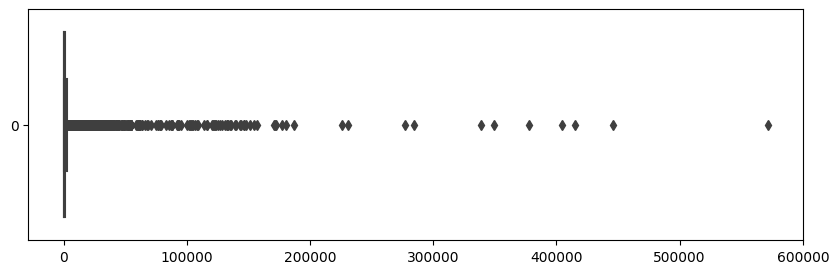

In [41]:
plt.figure(figsize=(10, 3))
sns.boxplot(dataset['user_count_3months'], orient='h')

In [33]:
dataset.columns

Index(['actor', 'age_access_type', 'country', 'average_rating', 'duration',
       'type', 'name', 'release_year', 'genre', 'director', 'element_uid',
       'availability', 'users_number_x', 'users_number_y', 'subscription_only',
       'uid', 'user_count_3months', 'min_ts', 'year_month',
       'total_user_count_3months', 'total_user_count_3months_frac', 'target'],
      dtype='object')

In [43]:
# top watched
'Чикатило' in dataset[dataset['user_count_3months'] > 100000]['name']

False

In [35]:
# keep features relevant for training
final_features = ['actor', 'age_access_type', 'country', 'average_rating', 'duration', 'availability',
                   'type', 'name', 'release_year', 'genre', 'director', 'target', 'subscription_only', 'uid',
                 'user_count_3months']

dataset_final = dataset[dataset['min_ts'] <  datetime.datetime.strptime(f'2022.07', "%Y.%m")][final_features]
dataset_final.index = range(len(dataset_final))

In [36]:
dataset_final

,actor,age_access_type,country,average_rating,duration,availability,type,name,release_year,genre,director,target,subscription_only,uid,user_count_3months
0,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 21c7a45...",12,[usa],6.21,6420000,"[DTO, RENT, SUBSCRIPTION]",MOVIE,Звёздный путь 5: Последний рубеж,1989,"[Sci-Fi, Action, Thriller, Adventure]",[cff3362f-ad91-498d-80b3-ea3ab8ec65cf],8.508657e-07,False,e785baa6-f175-42b4-9e16-4319ac7991d5,6
1,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 21c7a45...",16,[usa],7.2,6780000,"[DTO, RENT, SUBSCRIPTION]",MOVIE,Звёздный путь 6: Неоткрытая страна,1991,"[Sci-Fi, Action, Thriller, Adventure]",[bab6b7f4-4506-458f-9091-d567505674f2],1.559920e-06,False,4593737e-de9c-40df-97db-fb3cf85a08ef,11
2,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, bcad17e...",18,[usa],4.0,6000000,"[DTO, RENT, SUBSCRIPTION]",MOVIE,В поисках древнего артефакта,2019,[Horror],[895f5774-964a-4c5a-ae22-d697d3e3e620],3.578051e-06,False,11ba66db-e941-4c3a-8da6-d8900e56f8c7,19
3,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 30dd19c...",18,[usa],6.99,3780000,[SUBSCRIPTION],MOVIE,Прожарка Чарли Шина,2011,"[Comedy, Documentary]",[1de22aff-430e-4af9-bf1d-159dbf8e9269],3.544765e-04,True,3f30a2ef-53b7-40e3-954f-1bdfc38a6d17,1637
4,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, a805fdd...",18,[usa],6.0,3780000,[SUBSCRIPTION],MOVIE,Прожарка Уильяма Шэтнера,2006,[Comedy],[1de22aff-430e-4af9-bf1d-159dbf8e9269],6.394210e-05,True,cdfa700f-122d-41e5-b8dc-9c6813bab6d2,322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11661,"[98a0a20e-00b6-495d-a928-d586b9ada1f2, 4a04da5...",16,[ukraine],NaN,29040000,[SUBSCRIPTION],SERIAL,"Мульт ""Кухня""",2017,"[Comedy, 287a1485-7a88-4c2f-bc94-ca418b6c47a1]","[3448123b-358d-4c61-8247-070226d29e4e, 8465df4...",6.131349e-06,True,29267cec-df59-4e0a-9304-106a1156cb5c,39
11662,"[0c8e7bd6-d351-4fe1-a444-a948946a16f0, 0747980...",12,[russia],6.9,12240000,[SUBSCRIPTION],SERIAL,Без памяти,2021,"[Comedy, Melodrama]",[a2e96430-845c-4434-a438-0eb4021bd6cc],2.351608e-03,True,db608d74-b09e-4636-9ebc-0a21c7a9d8dd,14958
11663,"[cd3667dd-d887-48ea-aa37-f45dab705621, c9ce318...",0,[russia],NaN,2400000,"[SUBSCRIPTION, AVOD]",SERIAL,Три кота. Специальные серии,2020,[287a1485-7a88-4c2f-bc94-ca418b6c47a1],[579239ea-e838-43f5-b321-9eb365125489],5.349995e-03,False,4fd7d857-4718-4e72-bff6-6448d2cd0a1e,34030
11664,"[1a600720-d270-4162-97fd-a831d36a1769, 1c99088...",16,[south-korea],7.8,8400000,"[SUBSCRIPTION, AVOD]",SERIAL,Всплеск любви,2015,"[Melodrama, 9fa28b61-a257-4a3e-945b-a9ef76a146d6]",[321974f4-eae4-4d87-86c7-52b37b1cad50],3.232321e-04,False,d505b747-5cb4-4ffd-b4bb-b037100f57ab,2056


In [38]:
with open('/home/jovyan/work/cold_start_models/item_coldstart_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_final, f)

# with open('item_coldstart_dataset_full.pkl', 'wb') as f:
#     pickle.dump(dataset, f)

In [39]:
dataset_final.columns

Index(['actor', 'age_access_type', 'country', 'average_rating', 'duration',
       'availability', 'type', 'name', 'release_year', 'genre', 'director',
       'target', 'subscription_only', 'uid', 'user_count_3months'],
      dtype='object')